# BreastDCEDL 
## Vit Predict on BreastDCEDL 

#### Author: Tomer Fridman
#### Date: 2025-05-12
> BreastDCEDL/BreastDCEDL/BrestDCEDL_vit_predict.ipynb

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/naomifridman/BreastDCEDL/blob/main/BrestDCEDL_vit_predict.ipynb)

In [16]:
from sklearn.metrics import classification_report,auc,roc_auc_score
from PIL import Image
import time
from pathlib import Path


import os
import numpy as np
import pandas as pd
from PIL import Image


import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from glob import glob
#from skimage import io
from sklearn.utils import shuffle

#from nipype.interfaces.ants import N4BiasFieldCorrection
import sys
import os
import ast

import warnings
warnings.filterwarnings('ignore')

In [17]:

my_computer=True
git_samples = True

# set to base of your nifti data
base_path="G:\\My Drive\\breast_mri"

In [18]:
# Check if running in Google Colab

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab")
    # Clone the repository
    !git clone https://github.com/naomifridman/BreastDCEDL.git

    # Change to the repository directory
    os.chdir('/content/BreastDCEDL')
    
    git_samples = True
    my_computer=False
    base_path='.'

In [19]:
# use if  nifti data is downloaded

nifti_path= {'spy2':os.path.join(base_path,"SPY2","vis1","dce"),
                        'spy1':os.path.join(base_path,"SPY1","vis1","dce"),
                        'duke':os.path.join(base_path,"DUKE","dce")}

mask_path={'spy2':os.path.join(base_path,"SPY2","vis1","mask"),
                    'spy1':os.path.join(base_path,"SPY1","vis1","mask"),
                    'duke':os.path.join(base_path,"DUKE","mask")}

# use for data_samples
if git_samples:
    nifti_path= {'spy2':os.path.join('.',"ISPY2","data_samples","dce"),
                        'spy1':os.path.join('.',"ISPY1","data_samples","dce"),
                        'duke':os.path.join('.',"DUKE","data_samples","dce")}

    mask_path={'spy2':os.path.join('.',"ISPY2","data_samples","mask"),
                    'spy1':os.path.join('.',"ISPY1","data_samples","mask"),
                    'duke':os.path.join('.',"DUKE","data_samples","mask")}



In [20]:
import os, sys
sys.path.append(os.path.abspath( 'utils'))

import data_utils as ds

ds.setup_paths(base_path, nifti_path, mask_path)

NIfTI roots : {'spy2': '.\\ISPY2\\data_samples\\dce', 'spy1': '.\\ISPY1\\data_samples\\dce', 'duke': '.\\DUKE\\data_samples\\dce'}
Mask  roots : {'spy2': '.\\ISPY2\\data_samples\\mask', 'spy1': '.\\ISPY1\\data_samples\\mask', 'duke': '.\\DUKE\\data_samples\\mask'}


## Load metada

In [21]:
df=pd.read_csv('BreastDCEDL_metadata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2070 non-null   object 
 1   pCR             1452 non-null   float64
 2   n_xy            2070 non-null   float64
 3   n_z             2070 non-null   float64
 4   n_times         2070 non-null   float64
 5   pre             2070 non-null   float64
 6   post_early      2070 non-null   float64
 7   post_late       2070 non-null   float64
 8   slice_thick     2070 non-null   float64
 9   xy_spacing      2070 non-null   float64
 10  mask_start      2070 non-null   float64
 11  mask_end        2070 non-null   float64
 12  sraw            2070 non-null   float64
 13  eraw            2070 non-null   float64
 14  scol            2070 non-null   float64
 15  ecol            2070 non-null   float64
 16  tum_vol         1456 non-null   float64
 17  age             2070 non-null   f

In [22]:
df.test.value_counts(dropna=False)

0.0    1531
1.0     271
2.0     268
Name: test, dtype: int64

In [23]:
df.pCR.value_counts(dropna=False)

0.0    1024
NaN     618
1.0     428
Name: pCR, dtype: int64

In [24]:
pd.crosstab(df.test,df.pCR, dropna=False)

pCR,0.0,1.0
test,,
0.0,777,322
1.0,124,53
2.0,123,53


In [25]:
pd.crosstab(df.test,df.HR, dropna=False)

HR,0.0,1.0
test,,
0.0,542,987
1.0,98,173
2.0,101,167


In [26]:
pd.crosstab(df.test,df.HER2, dropna=False)

HER2,0.0,1.0
test,,
0.0,1183,345
1.0,213,56
2.0,210,58


# Define Model

In [27]:
import torch
device='cpu'
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device='cuda'
else:
    print("CUDA is not available")


NVIDIA GeForce RTX 4070 Laptop GPU


In [28]:
from transformers import AutoImageProcessor,ViTConfig
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import ViTMAEForPreTraining, ViTFeatureExtractor, ViTForImageClassification
from torch.optim import AdamW
from tqdm import tqdm


checkpoint ='facebook/vit-mae-base'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

# Load the model with updated config
model = ViTForImageClassification.from_pretrained('facebook/vit-mae-base')
model.to(device);

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
model.load_state_dict(torch.load('./transformer_models/breastdcedl_pcr_vit_model_weights.pth'))

<All keys matched successfully>

In [81]:
def minmax(imc):
    im=imc.copy()
    if im.max()==0:
        return im
    return (im-im.min())/(im.max()-im.min())
           
def to_rgb(a,b,c):
    return minmax(np.stack([a,b,c],axis=2))

In [82]:
def get_jpg_im(pid, acq, k):

                
    im = to_rgb(acq[0][k],acq[1][k],acq[2][k])  
    im = Image.fromarray(im, mode="RGB")
    
    return im


In [83]:
_val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [84]:
def safe_crop_around_roi(img, roi_center_x, roi_center_y, crop_size=224):
    """
    Safely crop around ROI center, handling image boundaries

    Args:
        img: PIL Image
        roi_center_x: ROI center X coordinate
        roi_center_y: ROI center Y coordinate
        crop_size: Size of square crop (default 224)

    Returns:
        Cropped PIL Image of size (crop_size, crop_size)
    """
    img_width, img_height = img.size
    half_size = crop_size // 2

    # Calculate desired crop boundaries
    left = roi_center_x - half_size
    top = roi_center_y - half_size
    right = roi_center_x + half_size
    bottom = roi_center_y + half_size

    # Adjust if crop goes outside image boundaries
    if left < 0:
        right = right - left  # Shift right
        left = 0
    if top < 0:
        bottom = bottom - top  # Shift down
        top = 0
    if right > img_width:
        left = left - (right - img_width)  # Shift left
        right = img_width
    if bottom > img_height:
        top = top - (bottom - img_height)  # Shift up
        bottom = img_height

    # Final boundary check
    left = max(0, left)
    top = max(0, top)
    right = min(img_width, right)
    bottom = min(img_height, bottom)

    # Crop and resize if needed to ensure exact size
    img_cropped = img.crop((left, top, right, bottom))

    # If crop is smaller than desired size, resize to target size
    if img_cropped.size != (crop_size, crop_size):
        img_cropped = img_cropped.resize((crop_size, crop_size))

    return img_cropped



In [85]:
def predict_patient_images(model, pid, df, transform, device='cuda'):
    """
    Get patient photos, crop around ROI, resize to 256, transform, stack and predict
    """
    # Get patient row
    row = df[df['pid'] == pid].iloc[0]

    # Get slice range and ROI coordinates
    f = max(int(row['mask_start']), 0)
    l = min(int(row['mask_end']), int(row['n_z']))
    sr = int(row['sraw'])
    er = int(row['eraw'])
    sc = int(row['scol'])
    ec = int(row['ecol'])
    idx=(f+l)//2
    
    
    # Calculate ROI center
    roi_center_x = (sc + ec) // 2
    roi_center_y = (sr + er) // 2

    # Process all slices
    images_batch = []
    d = ds.get_all_nifti_acquisitions(pid)
    
    for k in range(max(idx-2, f), min(idx+2, l), 1):
        # Get image
        
        img = get_jpg_im(pid,d,k)

        # Crop around ROI
        #img_cropped = img.crop((sc, sr, ec, er))  # PIL crop: (left, top, right, bottom)
        img_cropped = safe_crop_around_roi(img, 
                                           roi_center_x, 
                                           roi_center_y,
                                           crop_size=224)
        # Convert to RGB and transform
        img_rgb = img_cropped.convert('RGB')
        img_transformed = transform(img_rgb)
        images_batch.append(img_transformed)

    # Stack and predict
    if images_batch:
        images_tensor = torch.stack(images_batch).to(device)  # (N, 3, H, W)

        model.eval()
        with torch.no_grad():
            outputs = model(images_tensor).logits
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Class 1 probabilities
            predictions = probs.cpu().numpy().tolist()
    else:
        predictions = []

    return predictions

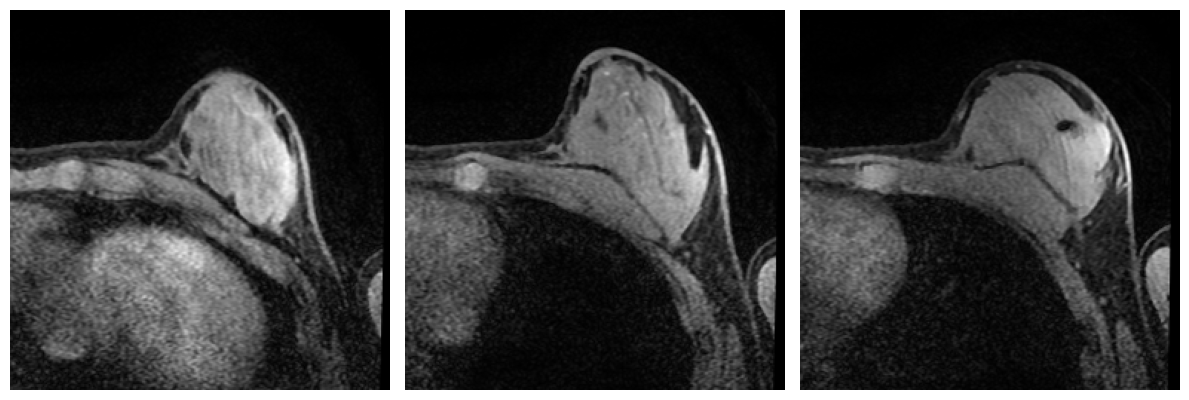

[0.5025172233581543, 0.500922679901123, 0.5156872272491455, 0.5071929097175598]

In [86]:
pid='ACRIN-6698-102212'
d=ds.get_all_nifti_acquisitions(pid)

ds.show_n_images([d[0][k] for k in [20,30,40]])
pred = predict_patient_images(model,pid,df,_val_transforms,device)
pred

In [87]:
df[df.pid==pid].T

,0
pid,ACRIN-6698-102212
pCR,0.0
n_xy,256.0
n_z,80.0
n_times,8.0
pre,0.0
post_early,2.0
post_late,6.0
slice_thick,2.0
xy_spacing,0.6055


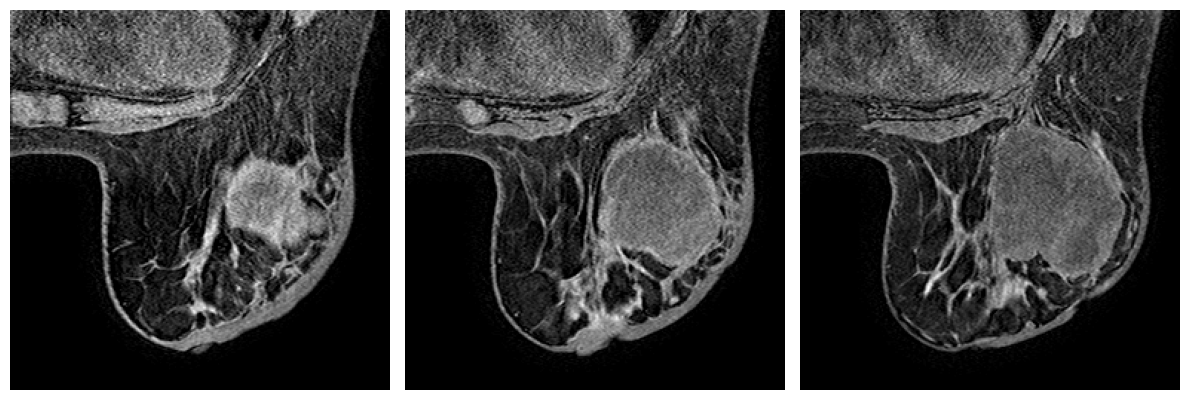

[0.49662578105926514,
 0.5078812837600708,
 0.5056902766227722,
 0.5047877430915833]

In [88]:
pid='ISPY2-550421'
d=ds.get_all_nifti_acquisitions(pid)

ds.show_n_images([d[0][k] for k in [70,80,90]])
pred = predict_patient_images(model,pid,df,_val_transforms,device)
pred

In [89]:
df[df.pid==pid].T

,642
pid,ISPY2-550421
pCR,0.0
n_xy,256.0
n_z,160.0
n_times,7.0
pre,0.0
post_early,2.0
post_late,6.0
slice_thick,1.0
xy_spacing,0.688073
